### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
from datasets import load_dataset
import fasttext
import optuna

/home/damian/Documents/Python/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preprocess

In [3]:
dataset = load_dataset("papluca/language-identification")

In [4]:
with open("train_data.txt", "w") as file:
    for label, text in zip(dataset["train"]["labels"], dataset["train"]["text"]):
        file.write("__label__" + label + " " + text + "\n")

In [5]:
with open("validation_data.txt", "w") as file:
    for label, text in zip(dataset["validation"]["labels"], dataset["validation"]["text"]):
        file.write("__label__" + label + " " + text + "\n")

In [6]:
with open("test_data.txt", "w") as file:
    for label, text in zip(dataset["test"]["labels"], dataset["test"]["text"]):
        file.write("__label__" + label + " " + text + "\n")

### Train data visualizations

In [7]:
train_texts = np.array([text for text in dataset["train"]["text"]])
train_labels = np.array([label for label in dataset["test"]["labels"]])

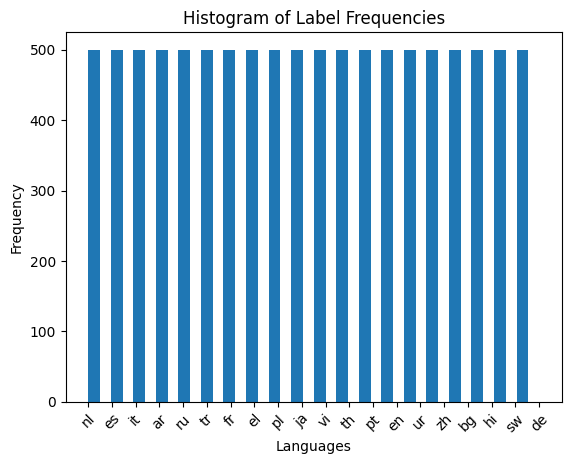

In [8]:
# histogram of label frequencies
plt.hist(train_labels, bins=len(set(train_labels)), width=0.5)
plt.xticks(rotation=45)
plt.xlabel('Languages')
plt.ylabel('Frequency')
plt.title('Histogram of Label Frequencies')
plt.show()

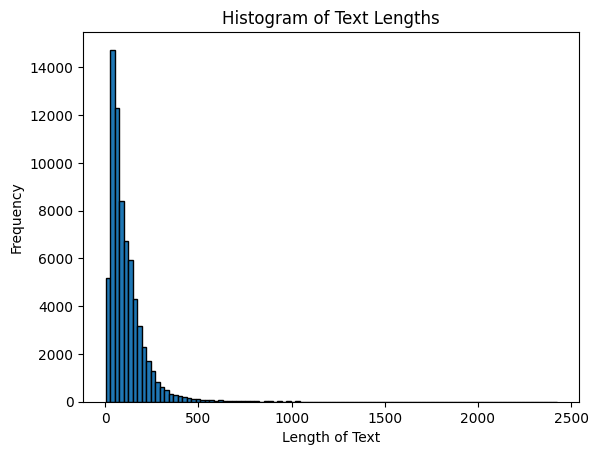

In [9]:
texts_lengths = [len(text) for text in train_texts]

# histogram of text lengths
plt.hist(texts_lengths, bins=100, edgecolor='black')  # Dzieli teksty na 10 przedziałów
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Histogram of Text Lengths')
plt.show()

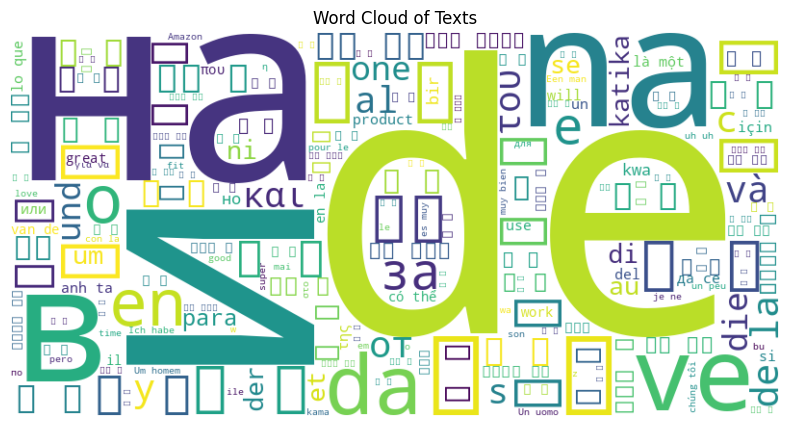

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_text(' '.join(train_texts))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Texts')
plt.show()

### First try

In [11]:
model = fasttext.train_supervised(input="train_data.txt", epoch=25, lr=1.0, wordNgrams=2)
result = model.test("validation_data.txt")
print(f"Model precision: {round(100*result[1], 2)}%")

Read 1M words
Number of words:  210220
Number of labels: 20
Progress:  95.7% words/sec/thread: 1128782 lr:  0.043389 avg.loss:  0.051859 ETA:   0h 0m 0s

Model precision: 86.25%


Progress: 100.0% words/sec/thread: 1130783 lr:  0.000000 avg.loss:  0.049712 ETA:   0h 0m 0s


### Example of use

In [12]:
sentences = [
    "To jest przykładowy tekst.",
    "Dies ist ein Beispieltext.",
    "This is an example text.",
    "Este es un texto de ejemplo.",
    "Ceci est un exemple de texte."
]

In [13]:
for sentence in sentences:
    predict = model.predict(sentence)
    print(f"Prediction: {predict[0][0].split('__')[-1]}, Confidence: {round(100*predict[1][0], 2)}%, Sentence: {sentence}")

Prediction: pl, Confidence: 100.0%, Sentence: To jest przykładowy tekst.
Prediction: de, Confidence: 100.0%, Sentence: Dies ist ein Beispieltext.
Prediction: en, Confidence: 99.38%, Sentence: This is an example text.
Prediction: es, Confidence: 99.99%, Sentence: Este es un texto de ejemplo.
Prediction: fr, Confidence: 99.97%, Sentence: Ceci est un exemple de texte.


### Model optimization

In [14]:
def objective(trial):

    params = {
        'epochs': trial.suggest_int('epochs', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
        'wordNgrams_value': trial.suggest_int('wordNgrams_value', 1, 4),
    }

    model = fasttext.train_supervised(input='train_data.txt',
                                      epoch=params['epochs'],
                                      lr=params['learning_rate'],
                                      wordNgrams=params['wordNgrams_value'])

    return model.test('validation_data.txt')[1]

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
print(study.best_trial.params)
print('Maximum validation precision: {:.4f}'.format(study.best_trial.value))

[I 2024-03-03 12:43:10,889] A new study created in memory with name: no-name-9e556f65-85a3-4f58-a92d-98c612852f23
Read 1M words
Number of words:  210220
Number of labels: 20
Progress: 100.0% words/sec/thread: 1250390 lr:  0.000000 avg.loss:  0.022287 ETA:   0h 0m 0s
[I 2024-03-03 12:43:18,477] Trial 0 finished with value: 0.8704 and parameters: {'epochs': 38, 'learning_rate': 0.43577098531124864, 'wordNgrams_value': 2}. Best is trial 0 with value: 0.8704.
Read 1M words
Number of words:  210220
Number of labels: 20
Progress: 100.0% words/sec/thread: 2223412 lr:  0.000000 avg.loss:  0.010676 ETA:   0h 0m 0s 19.0% words/sec/thread: 2248803 lr:  0.225840 avg.loss:  0.048637 ETA:   0h 0m 6s
[I 2024-03-03 12:43:27,471] Trial 1 finished with value: 0.879 and parameters: {'epochs': 87, 'learning_rate': 0.27897550768830126, 'wordNgrams_value': 1}. Best is trial 1 with value: 0.879.
Read 1M words
Number of words:  210220
Number of labels: 20
Progress: 100.0% words/sec/thread: 1331324 lr:  0.0000

Best trial:
{'epochs': 82, 'learning_rate': 0.19537619480161467, 'wordNgrams_value': 1}
Maximum validation precision: 0.8797


### Final model efficiency

In [16]:
model = fasttext.train_supervised(input="train_data.txt", epoch=80, lr=0.195, wordNgrams=1)
# final check on test data
result = model.test("test_data.txt")
print(f"Model precision: {round(100*result[1], 2)}%")

Read 1M words
Number of words:  210220
Number of labels: 20
Progress: 100.0% words/sec/thread: 2256428 lr:  0.000041 avg.loss:  0.012191 ETA:   0h 0m 0s

Model precision: 88.15%


Progress: 100.0% words/sec/thread: 2227882 lr:  0.000000 avg.loss:  0.012189 ETA:   0h 0m 0s
